# import

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import chainer

# データの取得

In [2]:
train, test = chainer.datasets.get_mnist()

## データの表示

引っ張ってきたデータの中身を見てみる

In [3]:
print(type(train))
print(len(train), len(test))
print(type(train[0]))

<class 'chainer.datasets.tuple_dataset.TupleDataset'>
60000 10000
<class 'tuple'>


それぞれ 60,000個, 10,000個のタプル配列のようだ

In [4]:
print(type(train[0][0]), type(train[0][1]))
# print((train[0][0]))
print(train[0][1])

<class 'numpy.ndarray'> <class 'numpy.int32'>
5


- train[n][0] には画像データが ndarray として格納されている
- train[n][1] にはラベルが int32 として格納されている

5


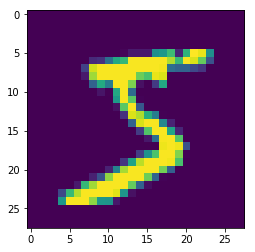

In [5]:
print(train[0][1])
img = train[0][0].reshape(28,28)
plt.imshow(img)

# ネットワーク定義

## import

In [6]:
from chainer import Sequential
import chainer.links as L
import chainer.functions as F

ニューラルネットワーク層を構成する関数群をライブラリとして提供している。<br> 
links, functions 以下に色々入っているので import しておく。

- Links: パラメータを持つ関数(層)
    - 全結合層など
- Functions: パラメータを持たない関数
    - シグモイドや ReLU など

In [7]:
for m in L.__dir__():
    if not str(m).startswith('__'):
        print(m)

activation
connection
Maxout
PReLU
SimplifiedDropconnect
Swish
Bias
Bilinear
Convolution2D
Convolution1D
Convolution3D
ConvolutionND
Deconvolution2D
Deconvolution1D
Deconvolution3D
DeconvolutionND
DeformableConvolution2D
DepthwiseConvolution2D
DilatedConvolution2D
EmbedID
GRU
StatefulGRU
StatelessGRU
Highway
Inception
normalization
InceptionBN
Linear
LocalConvolution2D
LSTM
StatelessLSTM
StatefulMGU
StatelessMGU
MLPConvolution2D
NStepBiGRU
NStepGRU
NStepBiLSTM
NStepLSTM
NStepBiRNNReLU
NStepBiRNNTanh
NStepRNNReLU
NStepRNNTanh
Parameter
StatefulPeepholeLSTM
Scale
ChildSumTreeLSTM
NaryTreeLSTM
StatefulZoneoutLSTM
loss
BlackOut
CRF1d
BinaryHierarchicalSoftmax
NegativeSampling
model
Classifier
GoogLeNet
ResNet101Layers
ResNet152Layers
ResNet50Layers
VGG16Layers
VGG19Layers
BatchNormalization
BatchRenormalization
DecorrelatedBatchNormalization
GroupNormalization
LayerNormalization
theano
TheanoFunction


In [8]:
for m in F.__dir__():
    if not str(m).startswith('__'):
        print(m)

activation
clipped_relu
relu6
crelu
elu
hard_sigmoid
leaky_relu
log_softmax
lstm
array
math
maxout
prelu
relu
rrelu
selu
sigmoid
slstm
softmax
softplus
swish
tanh
tree_lstm
as_strided
broadcast
broadcast_to
cast
concat
copy
depth2space
diagonal
dstack
expand_dims
flatten
flip
fliplr
flipud
get_item
hstack
im2col
moveaxis
pad
pad_sequence
permutate
repeat
reshape
resize_images
rollaxis
scatter_add
select_item
separate
space2depth
spatial_transformer_grid
spatial_transformer_sampler
split_axis
squeeze
stack
swapaxes
tile
transpose
transpose_sequence
vstack
where
connection
bilinear
convolution_2d
convolution_1d
convolution_3d
convolution_nd
deconvolution_2d
deconvolution_1d
deconvolution_3d
deconvolution_nd
deformable_convolution_2d_sampler
depthwise_convolution_2d
dilated_convolution_2d
embed_id
linear
local_convolution_2d
noise
n_step_bigru
n_step_gru
n_step_bilstm
n_step_lstm
n_step_birnn
n_step_rnn
shift
evaluation
accuracy
binary_accuracy
classification_summary
f1_score
precision
re

## Sequential によるネットワークの定義

In [9]:
n_input = 784
n_hidden = 100
n_output = 10

- n_input: mnist なので 784
- n_hidden: 隠れ層の数、適当に設定
- n_output: mnist なので 10

In [10]:
# net としてインスタンス化
net = Sequential(
    L.Linear(n_input, n_hidden), F.relu,
    L.Linear(n_hidden, n_hidden), F.relu,
    L.Linear(n_hidden, n_output)
)

## 目的関数の選択

分類タスクによく用いられる**交差エントロピー**を用いる。<br>
Chainer では以下のように呼べる
```
softmax_cross_entropy(予測値, ラベル)
```

## 最適化手法の選択

Chainer では　`chainer.optimizers` に様々な最適化手法のためのクラスが用意されている。

In [11]:
for m in chainer.optimizers.__dir__():
    if not str(m).startswith('__'):
        print(m)

ada_delta
AdaDelta
ada_grad
AdaGrad
adam
Adam
corrected_momentum_sgd
CorrectedMomentumSGD
momentum_sgd
MomentumSGD
msvag
MSVAG
nesterov_ag
NesterovAG
rmsprop
RMSprop
rmsprop_graves
RMSpropGraves
sgd
SGD
smorms3
SMORMS3


今回は、最適化手法として `確率的勾配降下法(SGD)` を利用する

In [12]:
optimizer = chainer.optimizers.SGD(lr=0.01)

作成した `optimizer` に `net` をセットしてパラメータ更新が `optimizer` によって行われるようにする

In [13]:
optimizer.setup(net)

## 訓練する

エポック数とバッチサイズの決定

In [14]:
n_epoch = 30
n_batchsize = 100

訓練の実行

In [15]:
x_train = train._datasets[0]
t_train = train._datasets[1]
x_val   = test._datasets[0]
t_val   = test._datasets[1]

In [16]:
iteration = 0

# ログの保存用
results_train = {
    'loss': [],
    'accuracy': []
}
results_valid = {
    'loss': [],
    'accuracy': []
}

for epoch in range(n_epoch):

    # データセット並べ替えた順番を取得
    order = np.random.permutation(range(len(x_train)))

    # 各バッチ毎の目的関数の出力と分類精度の保存用
    loss_list = []
    accuracy_list = []

    for i in range(0, len(order), n_batchsize):
        # バッチを準備
        index = order[i:i+n_batchsize]
        x_train_batch = x_train[index]
        t_train_batch = t_train[index]

        # 予測値を出力
        y_train_batch = net(x_train_batch)

        # 目的関数を適用し、分類精度を計算
        loss_train_batch = F.softmax_cross_entropy(y_train_batch, t_train_batch)
        accuracy_train_batch = F.accuracy(y_train_batch, t_train_batch)

        loss_list.append(loss_train_batch.array)
        accuracy_list.append(accuracy_train_batch.array)

        # 勾配のリセットと勾配の計算
        net.cleargrads()
        loss_train_batch.backward()

        # パラメータの更新
        optimizer.update()

        # カウントアップ
        iteration += 1

    # 訓練データに対する目的関数の出力と分類精度を集計
    loss_train = np.mean(loss_list)
    accuracy_train = np.mean(accuracy_list)

    # 1エポック終えたら、検証データで評価
    # 検証データで予測値を出力
    with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
        y_val = net(x_val)

    # 目的関数を適用し、分類精度を計算
    loss_val = F.softmax_cross_entropy(y_val, t_val)
    accuracy_val = F.accuracy(y_val, t_val)

    # 結果の表示
    print('epoch: {}, iteration: {}, loss (train): {:.4f}, loss (valid): {:.4f}'.format(
        epoch, iteration, loss_train, loss_val.array))

    # ログを保存
    results_train['loss'] .append(loss_train)
    results_train['accuracy'] .append(accuracy_train)
    results_valid['loss'].append(loss_val.array)
    results_valid['accuracy'].append(accuracy_val.array)

epoch: 0, iteration: 600, loss (train): 1.4492, loss (valid): 0.6476
epoch: 1, iteration: 1200, loss (train): 0.5150, loss (valid): 0.4043
epoch: 2, iteration: 1800, loss (train): 0.3873, loss (valid): 0.3423
epoch: 3, iteration: 2400, loss (train): 0.3387, loss (valid): 0.3072
epoch: 4, iteration: 3000, loss (train): 0.3097, loss (valid): 0.2848
epoch: 5, iteration: 3600, loss (train): 0.2884, loss (valid): 0.2704
epoch: 6, iteration: 4200, loss (train): 0.2714, loss (valid): 0.2547
epoch: 7, iteration: 4800, loss (train): 0.2570, loss (valid): 0.2451
epoch: 8, iteration: 5400, loss (train): 0.2444, loss (valid): 0.2340
epoch: 9, iteration: 6000, loss (train): 0.2331, loss (valid): 0.2242
epoch: 10, iteration: 6600, loss (train): 0.2227, loss (valid): 0.2180
epoch: 11, iteration: 7200, loss (train): 0.2132, loss (valid): 0.2070
epoch: 12, iteration: 7800, loss (train): 0.2043, loss (valid): 0.1990
epoch: 13, iteration: 8400, loss (train): 0.1961, loss (valid): 0.1912
epoch: 14, iterat

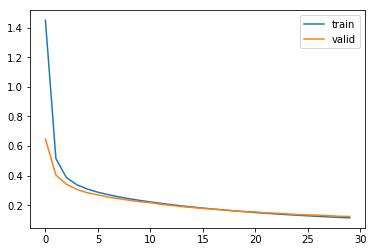

In [17]:
# 目的関数の出力
plt.plot(results_train['loss'], label='train')  # label で凡例の設定
plt.plot(results_valid['loss'], label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示

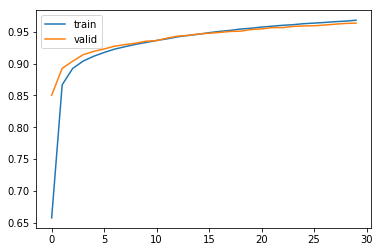

In [18]:
# 分類精度 (accuracy)
plt.plot(results_train['accuracy'], label='train')  # label で凡例の設定
plt.plot(results_valid['accuracy'], label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示